<a href="https://colab.research.google.com/github/yangr296/ECE539/blob/main/ECE539_DNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
#import data from drive
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
import imblearn

with open('/Users/publicenemy989/Downloads/parkinsons/parkinsons.data', 'r') as f:
  tmp = np.genfromtxt(f,delimiter=',')
np.set_printoptions(precision=3,suppress=True)

# with oversampling

Function def

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
def performSVM(X, y):
  aveScore = 0
  for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    aveScore += np.round(accuracy_score(y_test, y_pred), 3)
  aveScore /= 5
  return aveScore

def deleteColumn(matrix, columns):
  for i in range(len(columns)):
    matrix = np.delete(matrix, columns[i], 1)
    for j in range((i + 1), len(columns)):
      if columns[j] > columns[i]:
        columns[j] -= 1
  return matrix


In [90]:
def create_model(num, noise):
  net = tf.keras.models.Sequential([
      tf.keras.Input(shape=(5,)),
      tf.keras.layers.GaussianNoise(noise),
      tf.keras.layers.experimental.RandomFourierFeatures(output_dim=num, scale=5.0, kernel_initializer="gaussian"),
      tf.keras.layers.Dense(num, activation='relu'),
      # tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dense(num, activation='relu'),
      tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dense(2, activation='softmax'),
      ])
  net.compile(loss='poisson', optimizer='adam', metrics=['accuracy'])
  return net


In [91]:
def train_autoencoder(X, epoch_num=80):
    autoencoder = tf.keras.models.Sequential([
        tf.keras.Input(shape=(5,)),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.GaussianNoise(0.2),
        tf.keras.layers.Dense(5, activation='sigmoid'),
        tf.keras.layers.GaussianNoise(0.1),
    ])
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.fit(X, X, epochs=epoch_num, batch_size=74, verbose=0)
    X_pred = autoencoder.predict(X)
    return X_pred

In [92]:
from sklearn.model_selection import RepeatedKFold
from imblearn.over_sampling import RandomOverSampler

def perform_KF(X, y, noise=0.15, num=152, repeat=20, epoch_num=240, batch_size=70, AE_epoch_num=80, resample_epoch_num=50, resample_batch_size=20):
  ave_acc = 0
  kfold = RepeatedKFold(n_repeats=repeat, n_splits=3, random_state=0)
  print("noise: %f; num_neuron: %i; repeat: %i" %(noise, num, repeat))
  for i, (train_index, test_index) in enumerate(kfold.split(X)):
      print("fold %i" %i)

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # oversampling
      oversample = RandomOverSampler(sampling_strategy='all', random_state=None)
      X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

      y_train = keras.utils.to_categorical(y_train)
      y_train_resample = keras.utils.to_categorical(y_train_resample)
      
      autoencoder_sample = train_autoencoder(X_train_resample, epoch_num = AE_epoch_num)
      
      model = create_model(num, noise)
      model.fit(autoencoder_sample, y_train_resample, epochs=resample_epoch_num, batch_size=resample_batch_size, verbose=0)
      # model.fit(X_train_resample, y_train_resample, epochs=100, batch_size=74, verbose=0)
      model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size, verbose=0)

      y_pred = model.predict(X_test)
      y_pred = tf.argmax(y_pred, axis=1)
      y_test = tf.constant(y_test)

      accuracy = np.round(accuracy_score(y_test, y_pred), 5)
      ave_acc += accuracy
      print(f'Accuracy: {accuracy}')
  ave_acc = ave_acc / (3 * repeat)
  print("average accuracy is %f" %ave_acc)
  return ave_acc


In [93]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from keras.utils import plot_model

def print_metrics(X, y, noise=0.15, num=152, repeat=1, epoch_num=240, batch_size=70, AE_epoch_num=80, resample_epoch_num=50, resample_batch_size=20):
  ave_acc = 0
  kfold = RepeatedKFold(n_repeats=repeat, n_splits=3, random_state=0)
  print("noise: %f; num_neuron: %i; repeat: %i" %(noise, num, repeat))
  for i, (train_index, test_index) in enumerate(kfold.split(X)):
      print("fold %i" %i)

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # oversampling
      oversample = RandomOverSampler(sampling_strategy='all', random_state=None)
      X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

      y_train = keras.utils.to_categorical(y_train)
      y_train_resample = keras.utils.to_categorical(y_train_resample)
      
      autoencoder_sample = train_autoencoder(X_train_resample, epoch_num = AE_epoch_num)
      
      model = create_model(num, noise)
      model.fit(autoencoder_sample, y_train_resample, epochs=resample_epoch_num, batch_size=resample_batch_size, verbose=0)
      # model.fit(X_train_resample, y_train_resample, epochs=100, batch_size=74, verbose=0)
      model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size, verbose=0)

      y_pred = model.predict(X_test)
      y_pred = tf.argmax(y_pred, axis=1)
      y_test = tf.constant(y_test)

      accuracy = np.round(accuracy_score(y_test, y_pred), 5)
      ave_acc += accuracy
      print(f'Accuracy: {accuracy}')
      
      print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))
      
      fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
      roc_auc = metrics.auc(fpr, tpr)

      plt.title('Receiver Operating Characteristic')
      plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
      plt.legend(loc = 'lower right')
      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')
      plt.show()
      
  ave_acc = ave_acc / (3 * repeat)
  print("average accuracy is %f" %ave_acc)
  return ave_acc

Data Preprocessing

In [94]:
from tensorflow import keras

np.random.seed(0)
X, y = tmp[1:, 1:], tmp[1:, -7]
X = np.delete(X, 16, 1)
X = X.astype(float)
"""
index by columns
X[0] MDVP:Fo(Hz)
X[1] MDVP:Fhi(Hz)
X[2] MDVP:Flo(Hz)
X[3] MDVP:Jitter(%)
X[4] MDVP:Jitter(Abs)
X[5] MDVP:RAP
X[6] MDVP:PPQ
X[7] Jitter:DDP
X[8] MDVP:Shimmer
X[9] MDVP:Shimmer(dB)
X[10] Shimmer:APQ3
X[11] Shimmer:APQ5
X[12] MDVP:APQ
X[13] Shimmer:DDA
X[14] NHR
X[15] HNR
X[16] RPDE
X[17] DFA
X[18] spread1
X[19] spread2
X[20] D2
X[21] PPE
"""

'\nindex by columns\nX[0] MDVP:Fo(Hz)\nX[1] MDVP:Fhi(Hz)\nX[2] MDVP:Flo(Hz)\nX[3] MDVP:Jitter(%)\nX[4] MDVP:Jitter(Abs)\nX[5] MDVP:RAP\nX[6] MDVP:PPQ\nX[7] Jitter:DDP\nX[8] MDVP:Shimmer\nX[9] MDVP:Shimmer(dB)\nX[10] Shimmer:APQ3\nX[11] Shimmer:APQ5\nX[12] MDVP:APQ\nX[13] Shimmer:DDA\nX[14] NHR\nX[15] HNR\nX[16] RPDE\nX[17] DFA\nX[18] spread1\nX[19] spread2\nX[20] D2\nX[21] PPE\n'

In [95]:
from sklearn.impute import KNNImputer

if np.sum(np.isnan(X)):
  print('Total of NaN before imputation:', np.sum(np.isnan(X)))
  imputer = KNNImputer(n_neighbors=2, weights="uniform")
  X1 = imputer.fit_transform(X)
  print('Total of NaN after imputation:', np.sum(np.isnan(X1)))
else:
  X1 = X
  print('no NaN')

no NaN


In [96]:
from scipy.stats import pearsonr
pair = []
for i in range(21):
  for j in range((i + 1), 22):
    a = X[:, i]
    b = X[:, j]
    corr, _ = pearsonr(a, b)
    if(corr > 0.95):
      pair.append([i, j])
      print("features %i and %i have corr of %f" %(i, j, corr))
print(pair)

features 3 and 5 have corr of 0.990276
features 3 and 6 have corr of 0.974256
features 3 and 7 have corr of 0.990276
features 5 and 6 have corr of 0.957317
features 5 and 7 have corr of 1.000000
features 6 and 7 have corr of 0.957319
features 8 and 9 have corr of 0.987258
features 8 and 10 have corr of 0.987625
features 8 and 11 have corr of 0.982835
features 8 and 12 have corr of 0.950083
features 8 and 13 have corr of 0.987626
features 9 and 10 have corr of 0.963198
features 9 and 11 have corr of 0.973751
features 9 and 12 have corr of 0.960977
features 9 and 13 have corr of 0.963202
features 10 and 11 have corr of 0.960070
features 10 and 13 have corr of 1.000000
features 11 and 13 have corr of 0.960072
features 18 and 21 have corr of 0.962435
[[3, 5], [3, 6], [3, 7], [5, 6], [5, 7], [6, 7], [8, 9], [8, 10], [8, 11], [8, 12], [8, 13], [9, 10], [9, 11], [9, 12], [9, 13], [10, 11], [10, 13], [11, 13], [18, 21]]


In [97]:
from sklearn import svm
deleted = []
for i in pair:
  if i[0] in deleted:
    print("skipped pair(%i, %i), because %i already deleted" %(i[0], i[1], i[0]))
    continue
  if i[1] in deleted:
    print("skipped pair(%i, %i), because %i already deleted" %(i[0], i[1], i[1]))
    continue
  A = X
  B = X
  A = np.delete(A, i[0], 1)
  B = np.delete(B, i[1], 1)
  score_a = performSVM(A, y)
  score_b = performSVM(B, y)
  if(score_a > score_b):
    delete = i[1]
  else:
    delete = i[0]
  deleted.append(delete)
  print("Accuracy: %i(%.3f) %i(%.3f) Delete %i" %(i[0], score_a, i[1], score_b, delete))
print(deleted)

Accuracy: 3(0.790) 5(0.780) Delete 5
Accuracy: 3(0.846) 6(0.800) Delete 6
Accuracy: 3(0.790) 7(0.790) Delete 3
skipped pair(5, 6), because 5 already deleted
skipped pair(5, 7), because 5 already deleted
skipped pair(6, 7), because 6 already deleted
Accuracy: 8(0.821) 9(0.815) Delete 9
Accuracy: 8(0.785) 10(0.831) Delete 8
skipped pair(8, 11), because 8 already deleted
skipped pair(8, 12), because 8 already deleted
skipped pair(8, 13), because 8 already deleted
skipped pair(9, 10), because 9 already deleted
skipped pair(9, 11), because 9 already deleted
skipped pair(9, 12), because 9 already deleted
skipped pair(9, 13), because 9 already deleted
Accuracy: 10(0.810) 11(0.810) Delete 11
Accuracy: 10(0.821) 13(0.800) Delete 13
skipped pair(11, 13), because 11 already deleted
Accuracy: 18(0.831) 21(0.816) Delete 21
[5, 6, 3, 9, 8, 11, 13, 21]


In [98]:
print("preprocessing")
print(X[:5,:])
X = deleteColumn(X, deleted)
print("postprocessing")
print(X[:5,:])

preprocessing
[[119.992 157.302  74.997   0.008   0.      0.004   0.006   0.011   0.044
    0.426   0.022   0.031   0.03    0.065   0.022  21.033   0.415   0.815
   -4.813   0.266   2.301   0.285]
 [122.4   148.65  113.819   0.01    0.      0.005   0.007   0.014   0.061
    0.626   0.031   0.045   0.044   0.094   0.019  19.085   0.458   0.82
   -4.075   0.336   2.487   0.369]
 [116.682 131.111 111.555   0.011   0.      0.005   0.008   0.016   0.052
    0.482   0.028   0.039   0.036   0.083   0.013  20.651   0.43    0.825
   -4.443   0.311   2.342   0.333]
 [116.676 137.871 111.366   0.01    0.      0.005   0.007   0.015   0.055
    0.517   0.029   0.04    0.038   0.088   0.014  20.644   0.435   0.819
   -4.118   0.334   2.406   0.369]
 [116.014 141.781 110.655   0.013   0.      0.007   0.009   0.02    0.064
    0.584   0.035   0.048   0.045   0.105   0.018  19.649   0.417   0.823
   -3.748   0.235   2.332   0.41 ]]
postprocessing
[[119.992 157.302  74.997   0.      0.011   0.022   0.03

In [99]:
Corr = []
for i in range(len(X[0])):
  feature = X[:, i]
  corr, _ = pearsonr(feature, y)
  Corr.append([abs(corr), i])
  print("Pearson's Correlation of feature", i, "is: %.3f" % corr)

Pearson's Correlation of feature 0 is: -0.384
Pearson's Correlation of feature 1 is: -0.166
Pearson's Correlation of feature 2 is: -0.380
Pearson's Correlation of feature 3 is: 0.339
Pearson's Correlation of feature 4 is: 0.267
Pearson's Correlation of feature 5 is: 0.348
Pearson's Correlation of feature 6 is: 0.364
Pearson's Correlation of feature 7 is: 0.189
Pearson's Correlation of feature 8 is: -0.362
Pearson's Correlation of feature 9 is: 0.309
Pearson's Correlation of feature 10 is: 0.232
Pearson's Correlation of feature 11 is: 0.565
Pearson's Correlation of feature 12 is: 0.455
Pearson's Correlation of feature 13 is: 0.340


In [100]:
# sort all the correlations
num = len(X[0])
Corr.sort()
print("ranking the %i lowest correlations: " %num)
for i in range(num):
  print("feature: %2d corr: %.3f" %(Corr[i][1], Corr[i][0]))

ranking the 14 lowest correlations: 
feature:  1 corr: 0.166
feature:  7 corr: 0.189
feature: 10 corr: 0.232
feature:  4 corr: 0.267
feature:  9 corr: 0.309
feature:  3 corr: 0.339
feature: 13 corr: 0.340
feature:  5 corr: 0.348
feature:  8 corr: 0.362
feature:  6 corr: 0.364
feature:  2 corr: 0.380
feature:  0 corr: 0.384
feature: 12 corr: 0.455
feature: 11 corr: 0.565


In [101]:
columns = []
for i in range(4):
  columns.append(Corr[i][1])
print(columns)

[1, 7, 10, 4]


In [102]:
print("preprocessing")
print(X[:5,:])
X = deleteColumn(X, columns)
print("postprocessing")
print(X[:5,:])

preprocessing
[[119.992 157.302  74.997   0.      0.011   0.022   0.03    0.022  21.033
    0.415   0.815  -4.813   0.266   2.301]
 [122.4   148.65  113.819   0.      0.014   0.031   0.044   0.019  19.085
    0.458   0.82   -4.075   0.336   2.487]
 [116.682 131.111 111.555   0.      0.016   0.028   0.036   0.013  20.651
    0.43    0.825  -4.443   0.311   2.342]
 [116.676 137.871 111.366   0.      0.015   0.029   0.038   0.014  20.644
    0.435   0.819  -4.118   0.334   2.406]
 [116.014 141.781 110.655   0.      0.02    0.035   0.045   0.018  19.649
    0.417   0.823  -3.748   0.235   2.332]]
postprocessing
[[119.992  74.997   0.      0.022   0.03   21.033   0.415  -4.813   0.266
    2.301]
 [122.4   113.819   0.      0.031   0.044  19.085   0.458  -4.075   0.336
    2.487]
 [116.682 111.555   0.      0.028   0.036  20.651   0.43   -4.443   0.311
    2.342]
 [116.676 111.366   0.      0.029   0.038  20.644   0.435  -4.118   0.334
    2.406]
 [116.014 110.655   0.      0.035   0.045  19

In [103]:
"""
# partition into training and validation set at 80/20 division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Converting y_r and y_t into one-hot encoding using a keras utility

y_test = keras.utils.to_categorical(y_test)
y_train = keras.utils.to_categorical(y_train)
"""

'\n# partition into training and validation set at 80/20 division\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n# Converting y_r and y_t into one-hot encoding using a keras utility\n\ny_test = keras.utils.to_categorical(y_test)\ny_train = keras.utils.to_categorical(y_train)\n'

In [104]:
from sklearn import preprocessing
print("before transformation\n--------------------")
for i in range(X.shape[1]):
  print("range of feature %i is %i"%(i, np.ptp(X[:,i])))
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-5, 5))
X = min_max_scaler.fit_transform(X)
print("after transformation\n--------------------")
for i in range(X.shape[1]):
  print("range of feature %i is %i"%(i, np.ptp(X[:,i])))

# standardize X
scaler = preprocessing.StandardScaler().fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
print(X.shape)

before transformation
--------------------
range of feature 0 is 171
range of feature 1 is 173
range of feature 2 is 0
range of feature 3 is 0
range of feature 4 is 0
range of feature 5 is 24
range of feature 6 is 0
range of feature 7 is 5
range of feature 8 is 0
range of feature 9 is 2
after transformation
--------------------
range of feature 0 is 10
range of feature 1 is 10
range of feature 2 is 10
range of feature 3 is 10
range of feature 4 is 10
range of feature 5 is 10
range of feature 6 is 10
range of feature 7 is 10
range of feature 8 is 10
range of feature 9 is 10
(195, 10)


# index by columns
X[0] MDVP:Fo(Hz)
X[1] MDVP:Fhi(Hz)
X[2] MDVP:Flo(Hz)
X[3] MDVP:Jitter(Abs)
X[4] Jitter:DDP
X[5] Shimmer:APQ3
X[6] MDVP:APQ
X[7] NHR
X[8] HNR
X[9] RPDE
X[10] DFA
X[11] spread1
X[12] spread2
X[13] D2

In [105]:
import pickle
f = open('DNN2_3best.pkl', 'rb')
combinations = pickle.load(f)
print(combinations)
f.close()
comb = [0, 5, 6, 7, 3]

[(0, 3, 6, 7), (0, 5, 6, 7), (0, 3, 4, 7)]


In [107]:
best_score = 0
scores = []
x1 = X[:, comb[0]].reshape((195, 1))
x2 = X[:, comb[1]].reshape((195, 1))
x3 = X[:, comb[2]].reshape((195, 1))
x4 = X[:, comb[3]].reshape((195, 1))
x5 = X[:, comb[4]].reshape((195, 1))
X_ = np.hstack((x1, x2, x3, x4, x5))

score = perform_KF(X_, y)
scores.append(score)
if(score > best_score):
    best_score = score 
print("best score is: %.3f" %best_score)

noise: 0.150000; num_neuron: 152; repeat: 20
fold 0
3/3 [==============================] - 0s 794us/step
Accuracy: 0.95385
fold 1
3/3 [==============================] - 0s 743us/step
Accuracy: 0.96923
fold 2
3/3 [==============================] - 0s 827us/step
Accuracy: 0.93846
fold 3
3/3 [==============================] - 0s 899us/step
Accuracy: 0.95385
fold 4
3/3 [==============================] - 0s 788us/step
Accuracy: 0.95385
fold 5
3/3 [==============================] - 0s 933us/step
Accuracy: 0.98462
fold 6
3/3 [==============================] - 0s 723us/step
Accuracy: 0.95385
fold 7
3/3 [==============================] - 0s 923us/step
Accuracy: 0.93846
fold 8
3/3 [==============================] - 0s 737us/step
Accuracy: 0.89231
fold 9
3/3 [==============================] - 0s 844us/step
Accuracy: 0.92308
fold 10
3/3 [==============================] - 0s 736us/step
Accuracy: 0.86154
fold 11
3/3 [==============================] - 0s 751us/step
Accuracy: 0.96923
fold 12
3/3 [====

noise: 0.150000; num_neuron: 152; repeat: 1
fold 0
3/3 [==============================] - 0s 881us/step
Accuracy: 0.95385
Confusion matrix: 
 [[14  0]
 [ 3 48]]


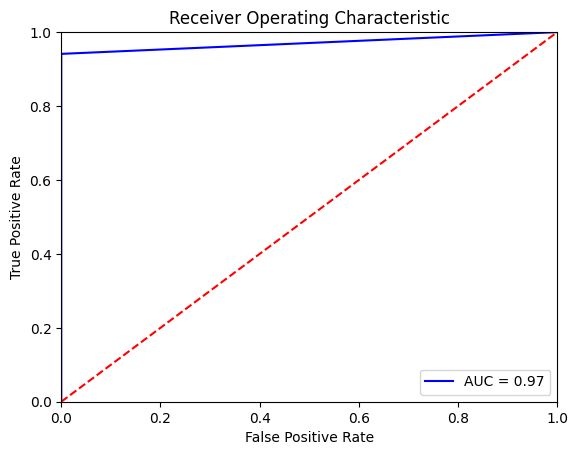

fold 1
3/3 [==============================] - 0s 787us/step
Accuracy: 0.93846
Confusion matrix: 
 [[15  0]
 [ 4 46]]


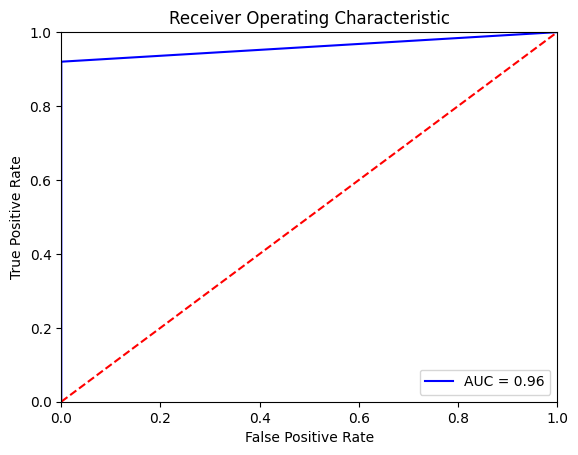

fold 2
3/3 [==============================] - 0s 775us/step
Accuracy: 0.90769
Confusion matrix: 
 [[15  4]
 [ 2 44]]


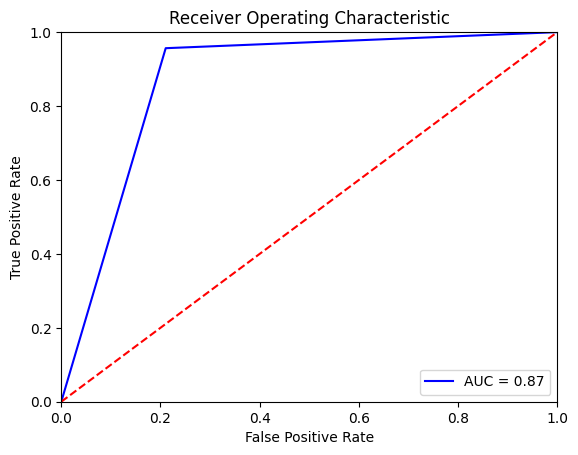

average accuracy is 0.933333
best score is:  0.9333333333333332


In [114]:
best_score = 0
scores = []
x1 = X[:, comb[0]].reshape((195, 1))
x2 = X[:, comb[1]].reshape((195, 1))
x3 = X[:, comb[2]].reshape((195, 1))
x4 = X[:, comb[3]].reshape((195, 1))
x5 = X[:, comb[4]].reshape((195, 1))
X_ = np.hstack((x1, x2, x3, x4, x5))

score = print_metrics(X_, y,)
scores.append(score)
if(score > best_score):
  best_score = score
print("best score is: ", best_score)

In [66]:
best_score = 0
scores = []
best_num = 0
nums = np.arange(160, 180, 10)
for num in nums:
  print("current num is %i" %num)
  x1 = X[:, comb[0]].reshape((195, 1))
  x2 = X[:, comb[1]].reshape((195, 1))
  x3 = X[:, comb[2]].reshape((195, 1))
  x4 = X[:, comb[3]].reshape((195, 1))
  x5 = X[:, comb[4]].reshape((195, 1))
  X_ = np.hstack((x1, x2, x3, x4, x5))

  score = perform_KF(X_, y, num=152, resample_batch_size=num)
  scores.append([score, num])
  if(score > best_score):
    best_score = score 
    best_num = num
  print("best score is: %.3f best num is %i" %(best_score, best_num))

current num is 160
noise: 0.150000; num_neuron: 152; repeat: 20
fold 0
3/3 [==============================] - 0s 831us/step
Accuracy: 0.96923
fold 1
3/3 [==============================] - 0s 782us/step
Accuracy: 0.95385
fold 2
3/3 [==============================] - 0s 1ms/step
Accuracy: 0.93846
fold 3
3/3 [==============================] - 0s 896us/step
Accuracy: 0.95385
fold 4
3/3 [==============================] - 0s 875us/step
Accuracy: 0.90769
fold 5
3/3 [==============================] - 0s 817us/step
Accuracy: 0.96923
fold 6
3/3 [==============================] - 0s 1ms/step
Accuracy: 0.93846
fold 7
3/3 [==============================] - 0s 867us/step
Accuracy: 0.93846
fold 8
3/3 [==============================] - 0s 1ms/step
Accuracy: 0.89231
fold 9
3/3 [==============================] - 0s 947us/step
Accuracy: 0.93846
fold 10
3/3 [==============================] - 0s 819us/step
Accuracy: 0.92308
fold 11
3/3 [==============================] - 0s 758us/step
Accuracy: 0.95385
fold

In [1620]:
"""
best_score = 0
best_comb = combinations[0]
best_num = 0
scores = []
nums = [128, 256, 512, 1024, 2048]
for comb in combinations:
  print("--------------------")
  x1 = X[:, comb[0]].reshape((195, 1))
  x2 = X[:, comb[1]].reshape((195, 1))
  x3 = X[:, comb[2]].reshape((195, 1))
  x4 = X[:, comb[3]].reshape((195, 1))
  X_ = np.hstack((x1, x2, x3, x4))
  for num in nums:
    print("current combination %s current num: %i" %(comb, num))
    score = perform_KF(X_, y, num)
    scores.append(score)
    if(score > best_score):
      best_score = score
      best_comb = comb
      best_num = num
print("best combination is: ", best_comb)
print("best score is: ", best_score)
print("best num is %i" %best_num)
"""

'\nbest_score = 0\nbest_comb = combinations[0]\nbest_num = 0\nscores = []\nnums = [128, 256, 512, 1024, 2048]\nfor comb in combinations:\n  print("--------------------")\n  x1 = X[:, comb[0]].reshape((195, 1))\n  x2 = X[:, comb[1]].reshape((195, 1))\n  x3 = X[:, comb[2]].reshape((195, 1))\n  x4 = X[:, comb[3]].reshape((195, 1))\n  X_ = np.hstack((x1, x2, x3, x4))\n  for num in nums:\n    print("current combination %s current num: %i" %(comb, num))\n    score = perform_KF(X_, y, num)\n    scores.append(score)\n    if(score > best_score):\n      best_score = score\n      best_comb = comb\n      best_num = num\nprint("best combination is: ", best_comb)\nprint("best score is: ", best_score)\nprint("best num is %i" %best_num)\n'